# ACP Project - Predicting Critical Events 

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap
shap.initjs()

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
class Notebook:
    OUTCOME = "CriticalEvent"
    MODELS = {}
    EXPLAINERS = {}


## Summary of results (*pre-tuning*)

See following sections for detailed results on each model, and the improvement achieved after tuning model parameters.

In [4]:
pd.read_csv("old_code/ml_test_4/results.csv").drop("dataset", axis=1).set_index(
    "model"
).sort_values("test_F2 Score", ascending=False)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB_OverUnder,19.782670,0.217722,0.958343,0.242830,0.684967,0.928427,0.358157,0.501435
XGB_Undersampling,4.260071,0.252587,0.958586,0.242177,0.671895,0.928159,0.354915,0.493959
LightGBM Weighted,7.850628,0.281921,0.966453,0.279089,0.610458,0.920652,0.381660,0.491394
LightGBM Balanced,11.450883,0.296697,0.959249,0.241540,0.650980,0.921191,0.351287,0.484377
LightGBM_SMOTE,6.433458,0.485369,0.951205,0.207203,0.661438,0.918630,0.314806,0.458349
LightGBM_SMOTE-Tomek,166.768970,0.531246,0.950519,0.204260,0.665359,0.919373,0.312320,0.457903
Random Forest_Undersampling,8.273318,2.149415,0.979337,0.404654,0.469281,0.930955,0.433802,0.454188
Random Forest_OverUnder,18.818681,1.158192,0.977613,0.370047,0.461438,0.929532,0.409668,0.438891
XGB_SMOTE,27.642934,0.214651,0.975801,0.341724,0.462745,0.909791,0.391558,0.430784


## Test Setup

### Thresholding/Tuning

In [5]:
from sklearn.metrics import precision_recall_curve

# def get_threshold(y_train, y_pred_proba, beta=10):
#     """ Given prediction probabilities, sets the prediction threshold to optimise the f-beta measure with specified beta
#     """

#     # Get candidate thresholds from the model, and find the one that gives the best fbeta score
#     precision, recall, thresholds = precision_recall_curve(
#         y_train, y_pred_proba
#     )
#     fbscore = ((1+beta**2) * precision * recall) / ((beta**2) * precision + recall)
#     closest = thresholds[fbscore.argmax()]
    
#     return closest

def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(
        y_train, y_pred_proba
    )
    closest = thresholds[np.abs(recall-target).argmin()]
    
    return closest

### Dataset

Different variations on this initial, pre-processed version will be tested throughout.

In [6]:
from dataset import SCIData, SCICols
%aimport dataset

#SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg()
sci = SCIData.load('data/sci_processed.h5').fix_readmissionband().derive_critical_event(within=2)

In [7]:
from sklearn.model_selection import train_test_split

scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, stratify=scii[Notebook.OUTCOME]
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.encode_ccs_onehot()
    .drop("HSMR_15", axis=1, errors="ignore")
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.encode_ccs_onehot()
    .drop("HSMR_15", axis=1, errors="ignore")
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)



In [8]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (main only)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (with missing)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Imputed vitals": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Missing NEWS, imputed blood": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Missing vitals": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
}


## Logistic Regression 

### NEWS only
Logistic regression (L2 penalty, by default) slightly beats the baseline NEWS model, which had AUC `0.807` for this outcome, but doesn't beat the original study score of `0.873`.

Balanced variant completely flips the precision vs. recall relationship, so it does a better job of minimising false-negatives. However, the final values are still low.

In [10]:
from sklearn.linear_model import LogisticRegression

datasets_lr = {
    "Raw NEWS": sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    "Scored NEWS": sci.mandate(SCICols.news_data_scored).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_scored, dtype=float
    ),
}

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "LR Balanced": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  score_time  test_Accuracy  test_Precision  \
dataset     model                                                              
Raw NEWS    LR           1.444137    0.071487       0.984029        0.585566   
            LR Balanced  0.919210    0.082112       0.862873        0.078060   
Scored NEWS LR           0.201792    0.082458       0.983853        0.543242   
            LR Balanced  0.205451    0.092430       0.858794        0.076380   

                         test_Recall  test_AUC  test_F1 Score  test_F2 Score  
dataset     model                                                             
Raw NEWS    LR              0.057346  0.817302       0.102924       0.069666  
            LR Balanced     0.663341  0.816260       0.139240       0.263397  
Scored NEWS LR              0.051167  0.813106       0.092838       0.062354  
            LR Balanced     0.673125  0.814827       0.136870       0.261209

In [11]:
spotCheckCV(
    {
        "LR": LogisticRegression(max_iter=1000, random_state=42),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, random_state=42), "LR"
        ),
    },
    *datasets_lr["Raw NEWS"]
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,1.504641,0.081116,0.984029,0.585566,0.057346,0.817302,0.102924,0.069666
LR_OverUnder,0.402602,0.085103,0.899116,0.093566,0.583043,0.815977,0.160729,0.283039
LR_SMOTE,2.902238,0.081115,0.873762,0.082232,0.649380,0.816472,0.145628,0.271427
LR_SMOTE-Tomek,9.435950,0.078779,0.870403,0.081396,0.654360,0.818666,0.144304,0.269685
LR_Undersampling,0.310834,0.077127,0.974944,0.254205,0.224921,0.818031,0.229506,0.224330


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.861302,0.074898,0.651403,0.806286,0.134349,0.256515


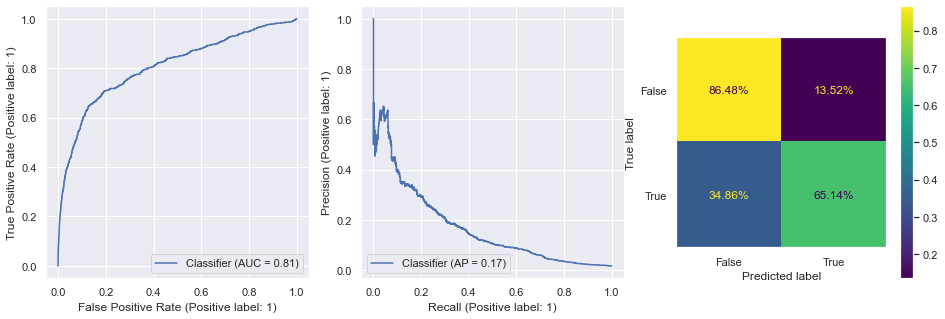

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    *sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    test_size=0.33,
    random_state=42
)

evaluate(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
        X_train, y_train
    ),
    X_test,
    y_test,
)


#### Thresholding

The baseline model's pre-defined risk ratio (NEWS score $\geq 7$) yields its own precision and recall "ratio". I.e., it balances false-positives and negatives in a certain way. We can emulate this tradeoff by adjusting the class threshold in the regression model. 

In [13]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score


def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    print(f"NEWS Precision={p:.5f}, Recall={r:.5f}")
    return p / r


# Get the "target" ratio of precision/recall that the NEWS threshold produces
target_ratio = get_news_target_ratio(
    *sci.mandate(SCICols.news_data_raw).xy(outcome=Notebook.OUTCOME)
)

# Train the LR model
model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000).fit(
    X_train, y_train
)

# Get candidate thresholds from the model, and find the one that gives the ratio closest to the target
precision, recall, thresholds = precision_recall_curve(
    y_train, model.predict_proba(X_train)[:, 1]
)
closest = thresholds[
    np.abs(
        np.divide(precision, recall, out=np.ones_like(recall), where=recall != 0)
        - target_ratio
    ).argmin()
]



NEWS Precision=0.22975, Recall=0.26733


On the test set, this gives much improved F2, while the AUC remains consistent (slightly better than baseline model).

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.973642,0.235217,0.264402,0.806286,0.248957,0.257999


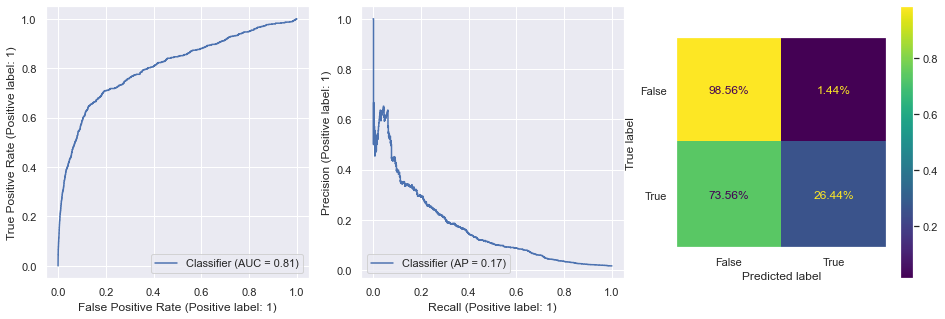

In [14]:
# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba[:, 1])


### Dataset Variants

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression (balanced)": LogisticRegression(
        max_iter=1000, class_weight="balanced"
    ),
    "Logistic Regression (saga)": Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    max_iter=1000,
                    class_weight="balanced",
                    solver="saga",
                    penalty="elasticnet",
                    l1_ratio=0.5,
                ),
            ),
        ]
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  \
dataset                                            model                                       
Imputed vitals                                     Logistic Regression             30.514350   
                                                   Logistic Regression (balanced)  28.903929   
                                                   Logistic Regression (saga)       9.525005   
Mandated vitals, Categorical diagnoses (main only) Logistic Regression              5.566777   
                                                   Logistic Regression (balanced)   5.296904   
                                                   Logistic Regression (saga)      25.986355   
Mandated vitals, Categorical diagnoses (with mi... Logistic Regression              5.372049   
                                                   Logistic Regression (balanced)   5.367022   
                                                   Logistic Regression (saga)      26.740158   
Mandated vitals, One-hot diagnoses                 Logistic Regression              7.275207   
                                                   Logistic Regression (balanced)   6.936065   
                                                   Logistic Regression (saga)      24.867549   
Missing NEWS, imputed blood                        Logistic Regression             28.882270   
                                                   Logistic Regression (balanced)  29.392135   
                                                   Logistic Regression (saga)      21.330128   
Missing vitals                                     Logistic Regression             29.627482   
                                                   Logistic Regression (balanced)  28.261723   
                                                   Logistic Regression (saga)      21.687380   

                                                                                   score_time  \
dataset                                            model                                        
Imputed vitals                                     Logistic Regression               0.101397   
                                                   Logistic Regression (balanced)    0.115860   
                                                   Logistic Regression (saga)        0.136612   
Mandated vitals, Categorical diagnoses (main only) Logistic Regression               0.039560   
                                                   Logistic Regression (balanced)    0.032923   
                                                   Logistic Regression (saga)        0.034230   
Mandated vitals, Categorical diagnoses (with mi... Logistic Regression               0.029254   
                                                   Logistic Regression (balanced)    0.033577   
                                                   Logistic Regression (saga)        0.036282   
Mandated vitals, One-hot diagnoses                 Logistic Regression               0.042220   
                                                   Logistic Regression (balanced)    0.047539   
                                                   Logistic Regression (saga)        0.049540   
Missing NEWS, imputed blood                        Logistic Regression               0.108376   
                                                   Logistic Regression (balanced)    0.124679   
                                                   Logistic Regression (saga)        0.137954   
Missing vitals                                     Logistic Regression               0.117352   
                                                   Logistic Regression (balanced)    0.126994   
                                                   Logistic Regression (saga)        0.140956   

                                                                                   test_Accuracy  \
dataset                                            model                                           
Imputed vitals        

### Resampling

In [27]:
dataset = datasets["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Logistic Regression (balanced)": LogisticRegression(
            max_iter=1000, class_weight="balanced"
        ),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000),
            "Logistic Regression",
            categorical_cols_idx,
        ),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, class_weight="balanced"),
            "Logistic Regression (balanced)",
            categorical_cols_idx,
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Logistic Regression,7.253267,0.047871,0.982718,0.455950,0.103268,0.888460,0.168222,0.122125
Logistic Regression (balanced),7.008555,0.043883,0.850962,0.085484,0.802614,0.890262,0.154385,0.299133
Logistic Regression (balanced)_OverUnder,5.570101,0.060837,0.864310,0.092187,0.773856,0.885741,0.164254,0.309998
Logistic Regression (balanced)_SMOTE,23.714572,0.053191,0.861503,0.088998,0.768627,0.883950,0.159233,0.302826
Logistic Regression (balanced)_SMOTE-Tomek,196.055287,0.077792,0.859117,0.087390,0.766013,0.884475,0.156606,0.298789
Logistic Regression (balanced)_Undersampling,1.843070,0.061834,0.847934,0.084762,0.811765,0.891669,0.153374,0.298362
Logistic Regression_OverUnder,4.625627,0.048204,0.926254,0.144724,0.669281,0.889413,0.236939,0.385114
Logistic Regression_SMOTE,19.817671,0.043218,0.861747,0.089795,0.772549,0.886242,0.160537,0.304904
Logistic Regression_SMOTE-Tomek,184.623241,0.078793,0.860023,0.088139,0.769935,0.884639,0.157880,0.300979


### Evaluation

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.852412,0.083403,0.77821,0.890191,0.150659,0.291886


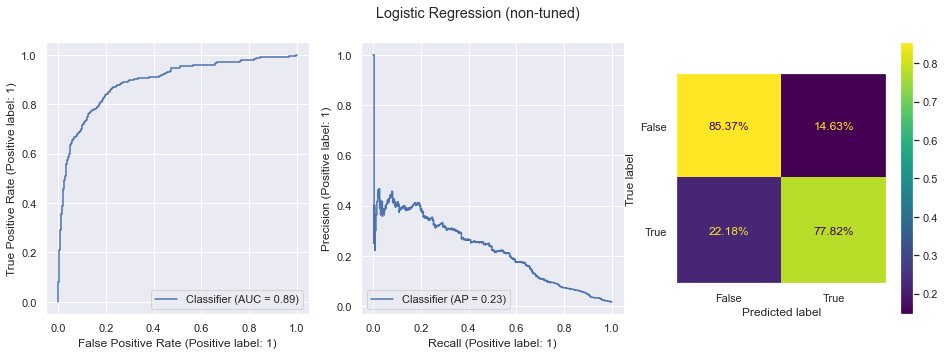

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_train, y_train)

evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save="images/eval_logistic_regression.png",
)

Notebook.MODELS["Logistic Regression"] = model


#### Thresholding

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.835788,0.076373,0.789883,0.890191,0.13928,0.275366


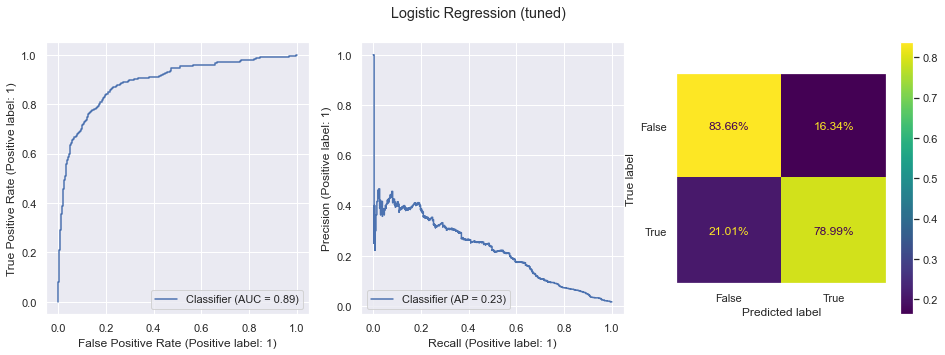

In [14]:
model = Notebook.MODELS["Logistic Regression"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save="images/eval_calibrated_logistic_regression.png",
)



### Explanations

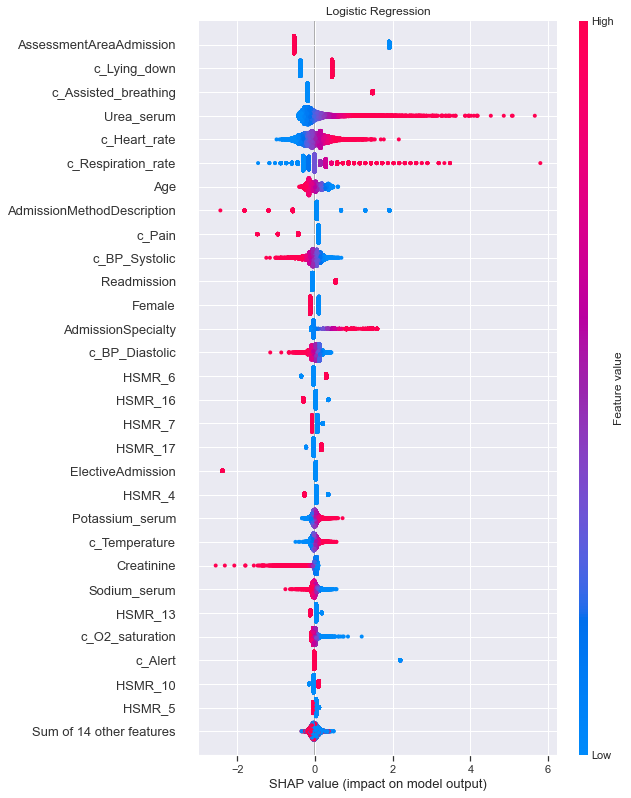

In [9]:
import shap

explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)
Notebook.EXPLAINERS["Logistic Regression"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("Logistic Regression")
plt.savefig("images/shap_swarm_logistic_regression.png", bbox_inches="tight")


In [221]:
positive_class_idx = np.where(model.predict(X_test))[0][105]
fig = shap.plots.force(shap_values[positive_class_idx])

shap.save_html("images/force_plot_logistic_regression.html", fig)
fig


## XGBoost

Achieves best-in-class performance (nearly matched by LightGBM). Performs best on the dataset variant with mandated vitals data and one-hot encoded diagnoses with random undersampling to combat the class imbalance.

### Dataset Variants

In [180]:
datasets_xgb = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .impute_blood()
        .augment_hsmr()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Imputed vitals, One-hot diagnoses": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Mandated NEWS, imputed blood, One-hot diagnoses": (
        scii.mandate_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing NEWS, imputed blood, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing blood & NEWS, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
}


In [190]:
from xgboost import XGBClassifier

xgb_weight_lambda = lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())

xgb_set_params = {
    "XGB Balanced": xgb_weight_lambda,
    "Hist XGB Balanced": xgb_weight_lambda,
}

models = {
    "Approx XGB": XGBClassifier(
        tree_method="approx", enable_categorical=True, scale_pos_weight=1
    ),
    "Approx XGB Balanced": XGBClassifier(
        tree_method="approx", enable_categorical=True,
    ),
    "Hist XGB": XGBClassifier(
        tree_method="hist", enable_categorical=True, scale_pos_weight=1
    ),
    "Hist XGB Balanced": XGBClassifier(tree_method="hist", enable_categorical=True,),
}

spotCheckDatasets(datasets=datasets_xgb, models=models, set_params=xgb_set_params)


fit_time  \
dataset                                         model                            
Imputed vitals, One-hot diagnoses               Approx XGB           34.244721   
                                                Approx XGB Balanced  33.393762   
                                                Hist XGB              5.515581   
                                                Hist XGB Balanced     5.515619   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB           19.603910   
                                                Approx XGB Balanced  23.299996   
                                                Hist XGB              4.594377   
                                                Hist XGB Balanced     4.985664   
Mandated vitals, Categorical diagnoses          Approx XGB           10.717001   
                                                Approx XGB Balanced  10.800445   
                                                Hist XGB              1.729041   
                                                Hist XGB Balanced     1.785557   
Mandated vitals, One-hot diagnoses              Approx XGB           10.959021   
                                                Approx XGB Balanced  10.903010   
                                                Hist XGB              1.836753   
                                                Hist XGB Balanced     1.837751   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB           41.996340   
                                                Approx XGB Balanced  33.177353   
                                                Hist XGB              7.086470   
                                                Hist XGB Balanced     5.646563   
Missing blood & NEWS, One-hot diagnoses         Approx XGB           33.257991   
                                                Approx XGB Balanced  33.032081   
                                                Hist XGB              7.419492   
                                                Hist XGB Balanced     5.597372   

                                                                     score_time  \
dataset                                         model                             
Imputed vitals, One-hot diagnoses               Approx XGB             1.188252   
                                                Approx XGB Balanced    1.168222   
                                                Hist XGB               1.306505   
                                                Hist XGB Balanced      1.286379   
Mandated NEWS, imputed blood, One-hot diagnoses Approx XGB             0.694487   
                                                Approx XGB Balanced    0.964088   
                                                Hist XGB               1.060165   
                                                Hist XGB Balanced      1.037558   
Mandated vitals, Categorical diagnoses          Approx XGB             0.398933   
                                                Approx XGB Balanced    0.409904   
                                                Hist XGB               0.409903   
                                                Hist XGB Balanced      0.404917   
Mandated vitals, One-hot diagnoses              Approx XGB             0.411235   
                                                Approx XGB Balanced    0.383811   
                                                Hist XGB               0.410901   
                                                Hist XGB Balanced      0.417217   
Missing NEWS, imputed blood, One-hot diagnoses  Approx XGB             1.244966   
                                                Approx XGB Balanced    1.252999   
                                                Hist XGB               1.361057   
                                                Hist XGB Balanced      1.326452   
Missing blood & NEWS, One-hot diagnoses         Approx XGB             1.218083   
                            

### Resampling

In [192]:
X, y = datasets_xgb["Mandated NEWS, imputed blood, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories().fillna(-1)
scale_pos_weight = y.shape[0] / y.sum()
spotCheckCV(
    {
        "XGB": XGBClassifier(
            tree_method="hist",
            enable_categorical=True,
            scale_pos_weight=scale_pos_weight,
        ),
        **with_sampling_strategies(
            XGBClassifier(
                tree_method="hist",
                enable_categorical=True,
                scale_pos_weight=scale_pos_weight,
            ),
            "XGB",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,1.280241,0.241022,0.979935,0.395952,0.377433,0.896903,0.384444,0.379790
XGB_OverUnder,7.152201,0.215424,0.950734,0.202623,0.658484,0.918907,0.309465,0.453285
XGB_SMOTE,15.870879,0.207778,0.972851,0.294024,0.439046,0.888170,0.352082,0.399523
XGB_SMOTE-Tomek,182.291634,0.236368,0.973175,0.297375,0.437759,0.883034,0.354057,0.399895
XGB_Undersampling,0.579449,0.215756,0.956912,0.229994,0.658559,0.923712,0.340065,0.478248


### Hyperparameters

In [424]:
param_grid = {
    "XGB__max_depth": np.arange(10, 25, 1),
    "XGB__learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "XGB__subsample": np.arange(0.3, 1.0, 0.05),
    "XGB__colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "XGB__colsample_bylevel": np.arange(0.6, 1.0, 0.05),
    "XGB__n_estimators": np.arange(50, 250, 10),
    "XGB__scale_pos_weight": np.arange(1, 60, 2),
}


In [420]:
from sklearn.model_selection import RandomizedSearchCV

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                scale_pos_weight=(y_train.shape[0] / (2 * y_train.sum())),
            ),
        ),
    ]
)

xgb_tuned = RandomizedSearchCV(
    model, param_distributions=param_grid, scoring=f2_score, n_iter=100, verbose=1
)



### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.967406,0.266925,0.536965,0.911673,0.356589,0.446602


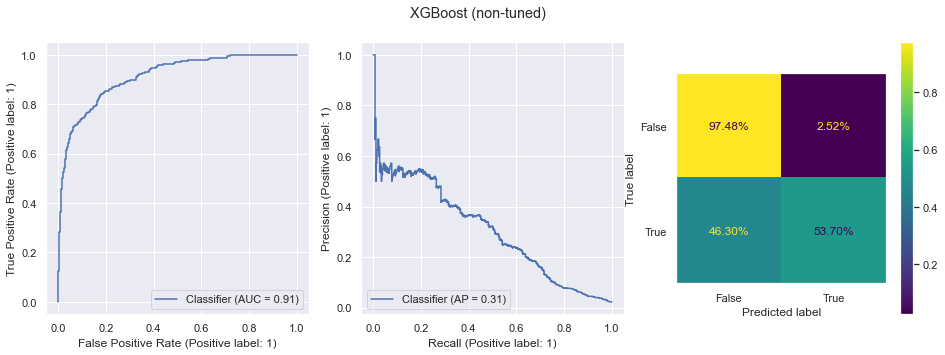

In [10]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                subsample=0.85,
                scale_pos_weight=31,
                n_estimators=140,
                max_depth=13,
                learning_rate=0.05,
                colsample_bytree=0.7,
                colsample_bylevel=0.9,
            ),
        ),
    ]
).fit(X_train, y_train)

evaluate(
    model, X_test, y_test, "XGBoost (non-tuned)", save="images/eval_xgboost.png"
)

Notebook.MODELS["XGBoost"] = model



#### Thresholding

We can further minimise false-negatives (at the expense of FPR) by altering the decision threshold manually. Below, we set it such that training recall/sensitivity approaches 0.95.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.69998,0.049927,0.933852,0.923864,0.094787,0.205656


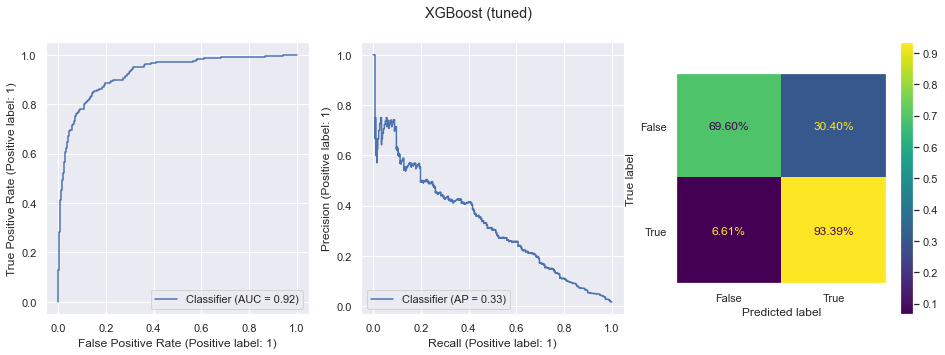

In [17]:
model = Notebook.MODELS["XGBoost"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > 1-threshold, 1, 0)

# Produce scores
evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save="images/eval_calibrated_xgboost.png",
)



### Explanations

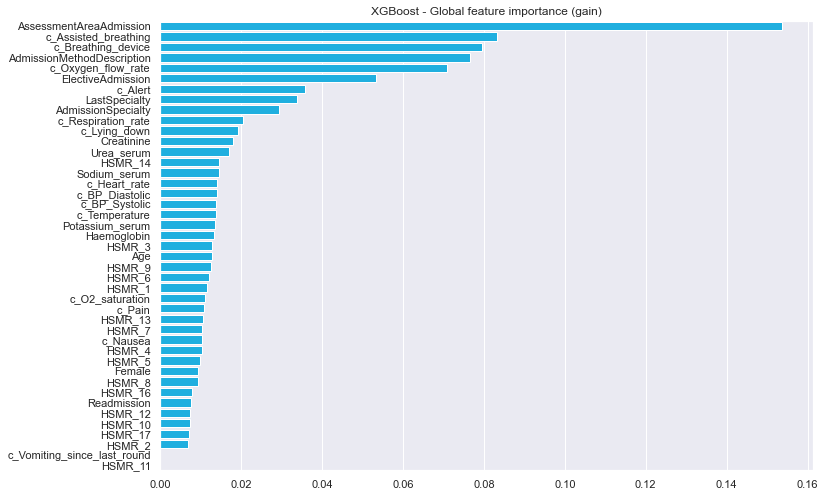

In [11]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("XGBoost - Global feature importance (gain)")
plt.savefig("images/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


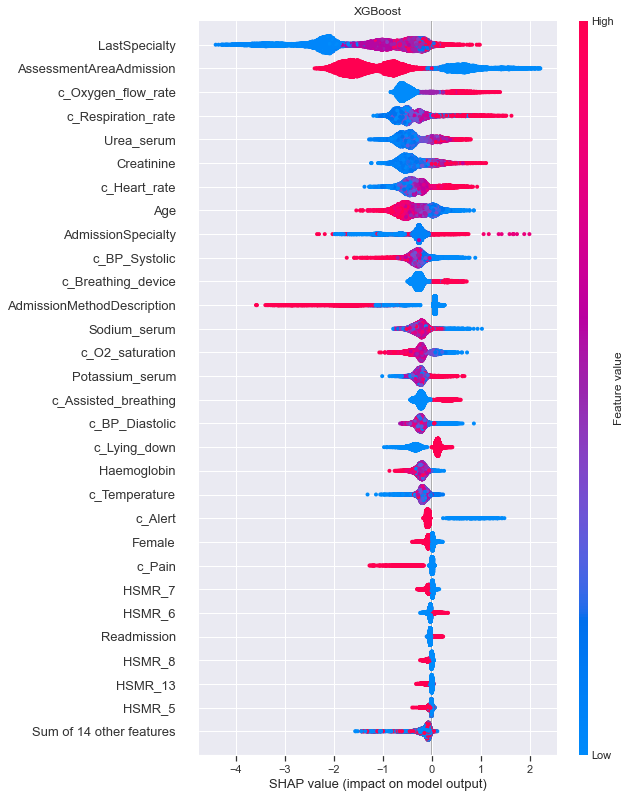

In [12]:
import shap

explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["XGBoost"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("XGBoost")
plt.savefig("images/shap_swarm_xgboost.png", bbox_inches="tight")


In [215]:
positive_class_idx = np.where(model.predict(X_test))[0][105]
fig = shap.plots.force(shap_values[positive_class_idx])

shap.save_html("images/force_plot_xgboost.html", fig)
fig


## Random Forest

### Dataset Variants

In [24]:
from sklearn.ensemble import RandomForestClassifier

models = {
    "Random Forest": RandomForestClassifier(),
    "Random Forest (balanced)": RandomForestClassifier(
        class_weight="balanced_subsample"
    ),
}


In [25]:
spotCheckDatasets(datasets=datasets, models=models)


fit_time  \
dataset                                            model                                 
Imputed vitals                                     Random Forest             28.479960   
                                                   Random Forest (balanced)  24.692130   
Mandated vitals, Categorical diagnoses (main only) Random Forest              5.459934   
                                                   Random Forest (balanced)   4.866982   
Mandated vitals, Categorical diagnoses (with mi... Random Forest              5.604026   
                                                   Random Forest (balanced)   5.040210   
Mandated vitals, One-hot diagnoses                 Random Forest              6.422156   
                                                   Random Forest (balanced)   5.785192   
Missing NEWS, imputed blood                        Random Forest             27.393974   
                                                   Random Forest (balanced)  25.239340   
Missing vitals                                     Random Forest             27.502067   
                                                   Random Forest (balanced)  25.129190   

                                                                             score_time  \
dataset                                            model                                  
Imputed vitals                                     Random Forest               2.870660   
                                                   Random Forest (balanced)    2.741665   
Mandated vitals, Categorical diagnoses (main only) Random Forest               0.563160   
                                                   Random Forest (balanced)    0.497003   
Mandated vitals, Categorical diagnoses (with mi... Random Forest               0.538891   
                                                   Random Forest (balanced)    0.522271   
Mandated vitals, One-hot diagnoses                 Random Forest               0.678186   
                                                   Random Forest (balanced)    0.574462   
Missing NEWS, imputed blood                        Random Forest               2.833780   
                                                   Random Forest (balanced)    2.738355   
Missing vitals                                     Random Forest               2.772282   
                                                   Random Forest (balanced)    2.736690   

                                                                             test_Accuracy  \
dataset                                            model                                     
Imputed vitals                                     Random Forest                  0.984049   
                                                   Random Forest (balanced)       0.983706   
Mandated vitals, Categorical diagnoses (main only) Random Forest                  0.983580   
                                                   Random Forest (balanced)       0.983227   
Mandated vitals, Categorical diagnoses (with mi... Random Forest                  0.983564   
                                                   Random Forest (balanced)       0.983283   
Mandated vitals, One-hot diagnoses                 Random Forest                  0.983448   
                                                   Random Forest (balanced)       0.983315   
Missing NEWS, imputed blood                        Random Forest                  0.984133   
                                                   Random Forest (balanced)       0.983791   
Missing vitals                                     Random Forest                  0.984061   
                                                   Random Forest (balanced)       0.983784   

                                                                             test_Precision  \
dataset                                            model                                      
Imputed vitals                     

### Resampling

In [26]:
dataset = datasets["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "Random Forest": RandomForestClassifier(),
        **with_sampling_strategies(
            RandomForestClassifier(), "Random Forest", categorical_cols_idx
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Random Forest,5.428974,0.581113,0.983337,0.685185,0.028758,0.903888,0.054756,0.035498
Random Forest_OverUnder,3.102823,0.593412,0.977326,0.356988,0.420915,0.922276,0.385579,0.405797
Random Forest_SMOTE,16.535836,0.564158,0.982983,0.499851,0.087582,0.914452,0.146458,0.104305
Random Forest_SMOTE-Tomek,178.128726,0.608869,0.983006,0.508790,0.091503,0.914805,0.154068,0.109225
Random Forest_Undersampling,1.037891,0.565487,0.978696,0.379733,0.389542,0.925640,0.381778,0.385662


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.979056,0.371429,0.354086,0.918547,0.36255,0.357423


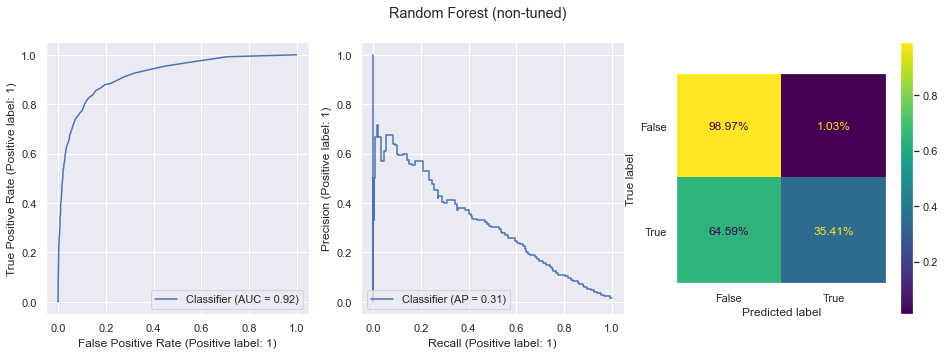

In [13]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("randomforest", RandomForestClassifier()),
    ]
).fit(X_train, y_train)

Notebook.MODELS["Random Forest"] = model

evaluate(
    model,
    X_test,
    y_test,
    plot_title="Random Forest (non-tuned)",
    save="images/eval_random_forest.png",
)



#### Thresholding

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.962759,0.249196,0.603113,0.915267,0.352673,0.469697


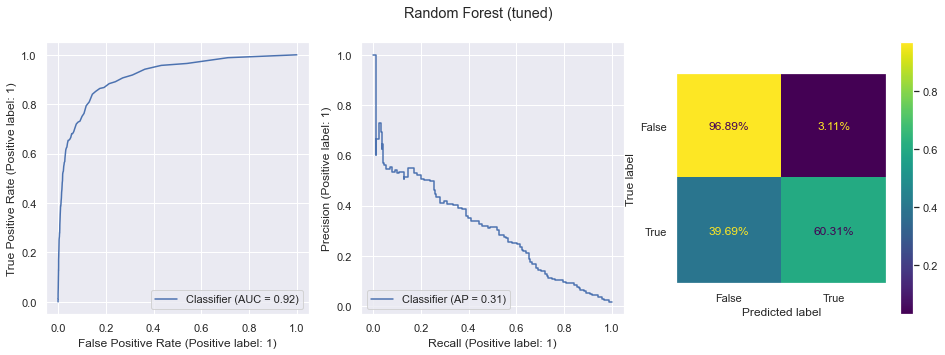

In [ ]:
model = Notebook.MODELS["Random Forest"]

threshold = get_threshold(
    y_train, 
    model.predict_proba(X_train)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > 1-threshold, 1, 0)

# Produce scores
evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save="images/eval_calibrated_random_forest.png",
)



### Explanations

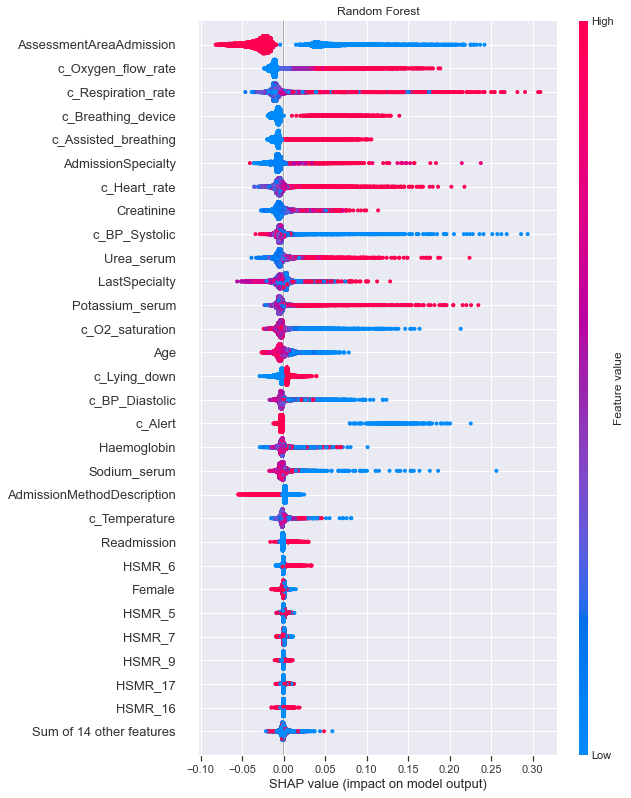

In [14]:
import shap

explainer = shap.TreeExplainer(model["randomforest"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["Random Forest"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=30, show=False)
plt.title("Random Forest")
plt.savefig("images/shap_swarm_random_forest.png", bbox_inches="tight")


In [265]:
positive_class_idx = np.where(model.predict(X_test))[0][105]
fig = shap.plots.force(shap_values[positive_class_idx, :, 1])

shap.save_html("images/force_plot_random_forest.html", fig)
fig


## Isolation Forest

Unlike other models tested, this is a one-class model that detects outliers instead of predicting outcomes. We test the hypothesis that "abnormal" values associated with the tracked outcome will be outliers compared to the normal ranges.

### Dataset Variants

In [89]:
models = {
    "Isolation Forest": IsolationForestWrapper(),
    "Isolation Forest (contamination)": IsolationForestWrapper(),
}
isolation_forest_set_params = {
    "Isolation Forest (contamination)": lambda X, y: dict(
        contamination=(y.sum()) / y.shape[0]
    )
}


In [90]:
spotCheckDatasets(
    datasets=datasets, models=models, set_params=isolation_forest_set_params
)


fit_time  \
dataset                                            model                                         
Imputed vitals                                     Isolation Forest                   7.279862   
                                                   Isolation Forest (contamination)  18.850247   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                   1.523923   
                                                   Isolation Forest (contamination)   3.872974   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                   1.598391   
                                                   Isolation Forest (contamination)   3.934144   
Mandated vitals, One-hot diagnoses                 Isolation Forest                   2.226046   
                                                   Isolation Forest (contamination)   5.093376   
Missing NEWS, imputed blood                        Isolation Forest                   7.159184   
                                                   Isolation Forest (contamination)  19.017467   
Missing vitals                                     Isolation Forest                   7.152205   
                                                   Isolation Forest (contamination)  18.853240   

                                                                                     score_time  \
dataset                                            model                                          
Imputed vitals                                     Isolation Forest                   11.707354   
                                                   Isolation Forest (contamination)   11.477967   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                    2.432494   
                                                   Isolation Forest (contamination)    2.400912   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                    2.452441   
                                                   Isolation Forest (contamination)    2.452108   
Mandated vitals, One-hot diagnoses                 Isolation Forest                    3.095720   
                                                   Isolation Forest (contamination)    2.852371   
Missing NEWS, imputed blood                        Isolation Forest                   11.754561   
                                                   Isolation Forest (contamination)   12.001567   
Missing vitals                                     Isolation Forest                   11.558417   
                                                   Isolation Forest (contamination)   11.587009   

                                                                                     test_Accuracy  \
dataset                                            model                                             
Imputed vitals                                     Isolation Forest                       0.903128   
                                                   Isolation Forest (contamination)       0.969204   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                       0.914431   
                                                   Isolation Forest (contamination)       0.969348   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                       0.922247   
                                                   Isolation Forest (contamination)       0.969482   
Mandated vitals, One-hot diagnoses                 Isolation Forest                       0.886697   
                                                   Isolation Forest (contamination)       0.968310   
Missing NEWS, imputed blood                        Isolation Forest                       0.837899   
                                                   Isolation Forest (contamination)       0.965730   
Missing vitals                                     Isolation Forest                       0.838891   


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.928268,0.103872,0.428016,0.834543,0.167173,0.263536


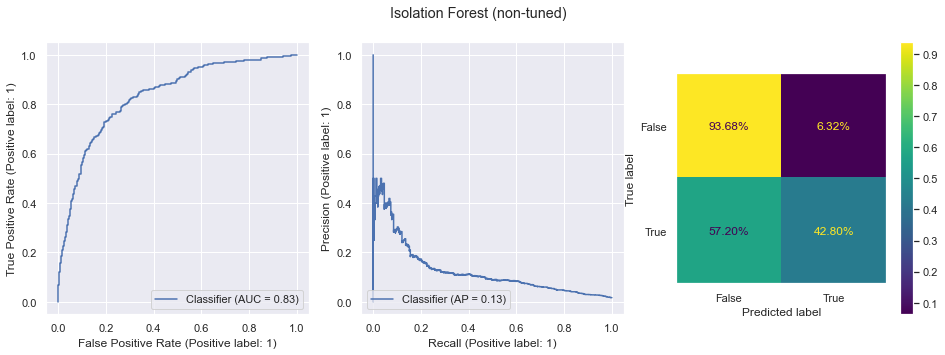

In [15]:
from sklearn.ensemble import IsolationForest

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
#X_train_if, y_train_if = X_train_if[~y_train_if], y_train_if[~y_train_if]


model = IsolationForestWrapper().fit(X_train_if.to_numpy())

Notebook.MODELS["Isolation Forest"] = model

evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save="images/eval_isolation_forest.png",
)


#### Thresholding

X has feature names, but IsolationForestWrapper was fitted without feature names
X has feature names, but IsolationForestWrapper was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.715923,0.045372,0.792829,0.837906,0.085831,0.184601


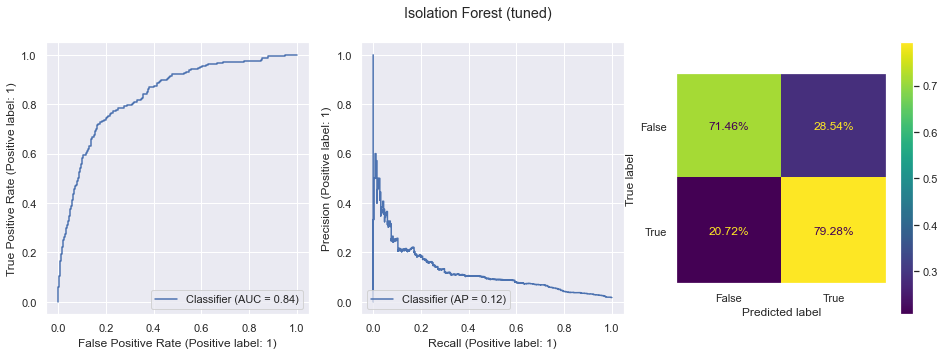

In [ ]:
model = Notebook.MODELS["Isolation Forest"]

y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(
    y_train_if, 
    y_pred_proba_train, 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba-y_pred_proba.min() > threshold, 1, 0)

evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save="images/eval_calibrated_isolation_forest.png",
)


### Explanations

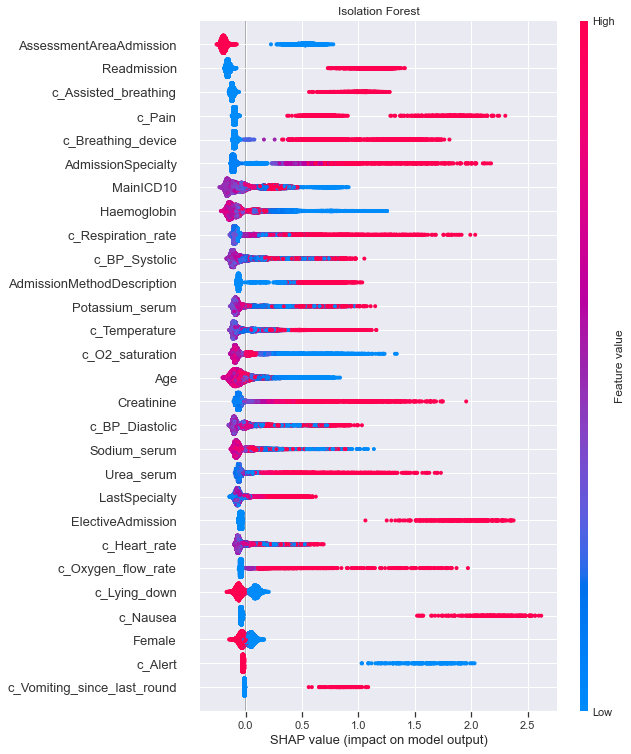

In [16]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS["Isolation Forest"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("Isolation Forest")
plt.savefig("images/shap_swarm_isolation_forest.png", bbox_inches="tight")


In [296]:
positive_class_idx = np.where(model.predict(X_test_if.to_numpy()))[0][105]
fig = shap.plots.force(shap_values[positive_class_idx])

shap.save_html("images/force_plot_random_forest.html", fig)
fig


## LightGBM

### Dataset Variants

In [111]:
from lightgbm import LGBMClassifier

lightgbm_set_params = {
    "LightGBM Weighted": lambda X, y: dict(scale_pos_weight=y.shape[0] / y.sum())
}

spotCheckDatasets(
    datasets=datasets_xgb,
    models={
        "LightGBM": LGBMClassifier(metric=["l2", "auc"]),
        "LightGBM Balanced": LGBMClassifier(metric=["l2", "auc"], is_unbalance=True),
        "LightGBM Weighted": LGBMClassifier(metric=["l2", "auc"]),
    },
    set_params=lightgbm_set_params,
)



fit_time  \
dataset                                        model                         
Imputed vitals, One-hot diagnoses              LightGBM           2.877636   
                                               LightGBM Balanced  3.123645   
                                               LightGBM Weighted  3.071118   
Mandated vitals, Categorical diagnoses         LightGBM           0.923529   
                                               LightGBM Balanced  0.976720   
                                               LightGBM Weighted  1.036560   
Mandated vitals, One-hot diagnoses             LightGBM           0.886628   
                                               LightGBM Balanced  0.935501   
                                               LightGBM Weighted  0.946467   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM           3.095719   
                                               LightGBM Balanced  3.264600   
                                               LightGBM Weighted  3.279893   
Missing blood & NEWS, One-hot diagnoses        LightGBM           3.134948   
                                               LightGBM Balanced  3.264269   
                                               LightGBM Weighted  3.299840   

                                                                  score_time  \
dataset                                        model                           
Imputed vitals, One-hot diagnoses              LightGBM             1.914213   
                                               LightGBM Balanced    2.263945   
                                               LightGBM Weighted    2.224385   
Mandated vitals, Categorical diagnoses         LightGBM             0.560501   
                                               LightGBM Balanced    0.707109   
                                               LightGBM Weighted    0.684171   
Mandated vitals, One-hot diagnoses             LightGBM             0.552855   
                                               LightGBM Balanced    0.559166   
                                               LightGBM Weighted    0.645939   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM             2.033229   
                                               LightGBM Balanced    2.598053   
                                               LightGBM Weighted    2.538876   
Missing blood & NEWS, One-hot diagnoses        LightGBM             2.069132   
                                               LightGBM Balanced    2.565139   
                                               LightGBM Weighted    2.490340   

                                                                  test_Accuracy  \
dataset                                        model                              
Imputed vitals, One-hot diagnoses              LightGBM                0.983668   
                                               LightGBM Balanced       0.904293   
                                               LightGBM Weighted       0.901243   
Mandated vitals, Categorical diagnoses         LightGBM                0.982441   
                                               LightGBM Balanced       0.964212   
                                               LightGBM Weighted       0.964017   
Mandated vitals, One-hot diagnoses             LightGBM                0.982254   
                                               LightGBM Balanced       0.962077   
                                               LightGBM Weighted       0.963602   
Missing NEWS, imputed blood, One-hot diagnoses LightGBM                0.983879   
                                               LightGBM Balanced       0.904386   
                                               LightGBM Weighted       0.904369   
Missing blood & NEWS, One-hot diagnoses        LightGBM                0.983879   
                                               LightGBM Balanced       0.904386   
                                               Lig

### Resampling

In [120]:
X, y = datasets_xgb["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = X.describe_categories()[0]
X = X.ordinal_encode_categories()
result = spotCheckCV(
    {
        "LightGBM": LGBMClassifier(
            metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()
        ),
        **with_sampling_strategies(
            LGBMClassifier(metric=["l2", "auc"], scale_pos_weight=y.shape[0] / y.sum()),
            "LightGBM",
            categorical_cols_idx,
        ),
    },
    X,
    y,
)

display(result)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LightGBM,0.884301,0.576791,0.959647,0.230466,0.584314,0.906326,0.329237,0.444946
LightGBM_OverUnder,2.648249,0.538892,0.917039,0.141010,0.754248,0.910544,0.237088,0.401771
LightGBM_SMOTE,6.433458,0.485369,0.951205,0.207203,0.661438,0.918630,0.314806,0.458349
LightGBM_SMOTE-Tomek,166.768970,0.531246,0.950519,0.204260,0.665359,0.919373,0.312320,0.457903
LightGBM_Undersampling,0.353054,0.557509,0.924685,0.154568,0.763399,0.929111,0.256519,0.425319


In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.085, 0.1, 0.15, 0.2, 0.25, 0.3],
    "boosting_type": ["gbdt", "dart", "goss"],
    "sub_feature": np.arange(0, 1, 0.05),
    "num_leaves": np.arange(20, 300, 20),
    "min_data": np.arange(10, 100, 10),
    "max_depth": np.arange(5, 200, 20),
    "scale_pos_weight": np.arange(1, 60, 2),
    "colsample_bytree": np.arange(0.1, 1.0, 0.05),
    "subsample": np.arange(0.3, 1.0, 0.05),
}


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.964657,0.276461,0.680934,0.942098,0.393258,0.526791


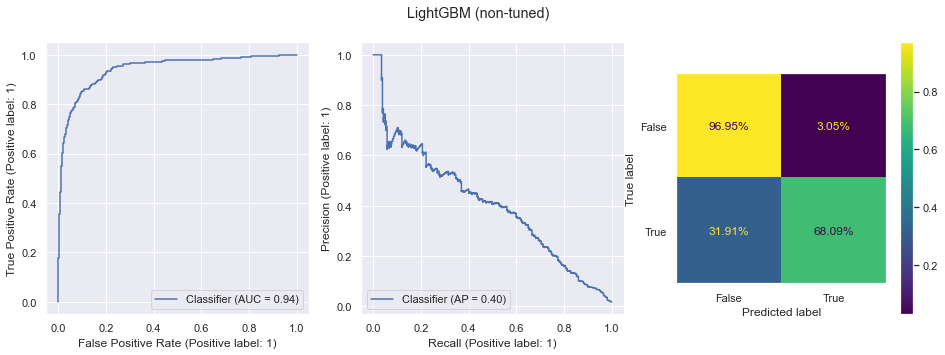

In [17]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = \
    sci_train.encode_ccs_onehot().drop("HSMR_15", axis=1, errors="ignore").xy(outcome=Notebook.OUTCOME, fillna=True), \
    sci_test.encode_ccs_onehot().drop("HSMR_15", axis=1, errors="ignore").xy(outcome=Notebook.OUTCOME, fillna=True),

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("lightgbm", LGBMClassifier(metric=["l2", "auc"], is_unbalance=True)),
    ]
).fit(X_train_lgbm, y_train_lgbm)

Notebook.MODELS["LightGBM"] = model

evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save="images/eval_lightgbm.png",
)


#### Recalibrating
We recalibrate to further minimise false-negatives. Here we set it such that training recall/sensitivity is 0.95.

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.862884,0.095866,0.848249,0.933183,0.172264,0.330103


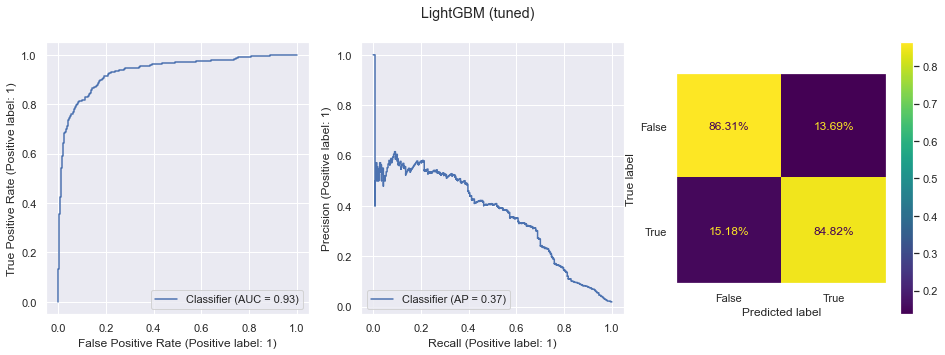

In [ ]:
model = Notebook.MODELS["LightGBM"]

threshold = get_threshold(
    y_test_lgbm, 
    model.predict_proba(X_test_lgbm)[:, 1], 
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save="images/eval_calibrated_lightgbm.png",
)


### Explanations

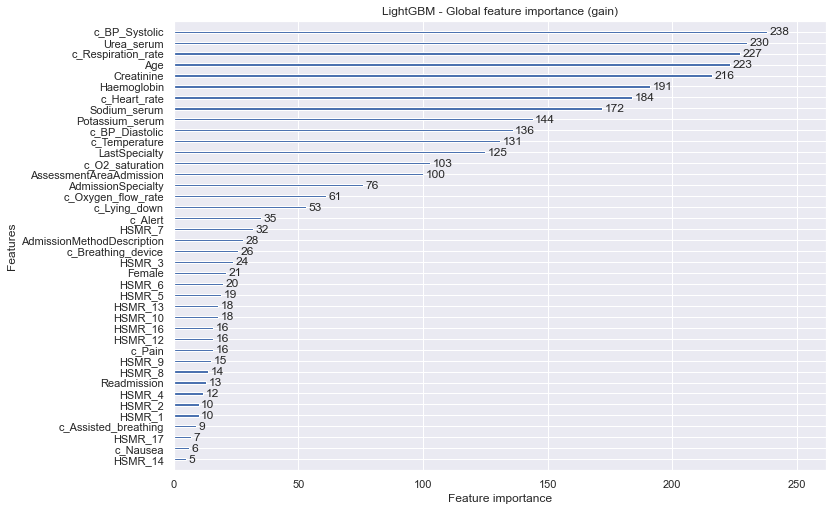

In [122]:
import lightgbm as lgb

fig = lgb.plot_importance(model["lightgbm"])
fig.set_title("LightGBM - Global feature importance (gain)")
plt.savefig("images/global_weights_lightgbm.png", bbox_inches="tight")



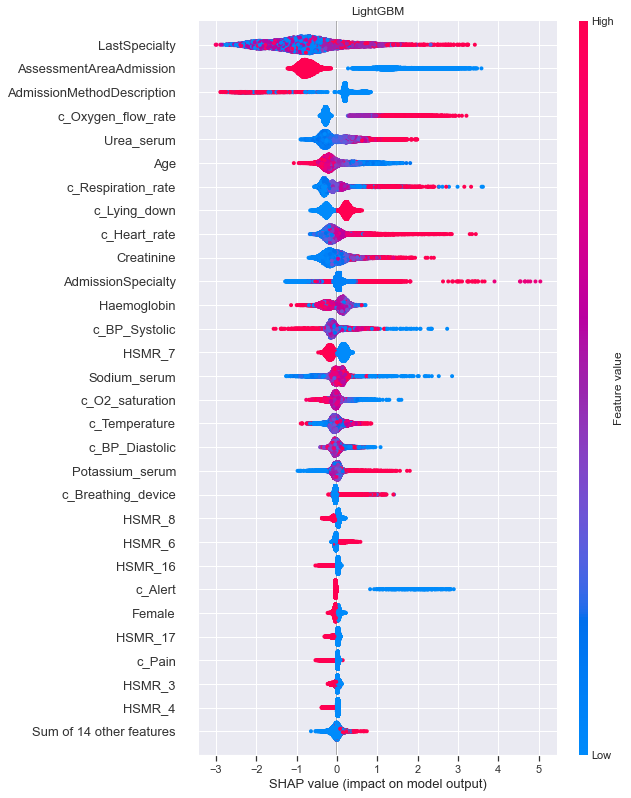

In [18]:
import shap

explainer = shap.TreeExplainer(model["lightgbm"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS["LightGBM"] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=30, show=False)
plt.title("LightGBM")
plt.savefig("images/shap_swarm_lightgbm.png", bbox_inches="tight")


In [126]:
positive_class_idx = np.where(model.predict(X_test_lgbm))[0][105]
fig = shap.plots.force(shap_values[positive_class_idx, :, 1])

shap.save_html("images/force_plot_lightgbm.html", fig)
fig


## TabNet

Deep-learning model for outcome prediction.

In [19]:
from sklearn.metrics import fbeta_score
from pytorch_tabnet.metrics import Metric


class F2TabNet(Metric):
    def __init__(self):
        self._name = "F2"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return fbeta_score(y_true, y_pred, beta=2)


In [21]:
categorical_cols_idx, categorical_cols_dims = SCIData(X_train).describe_categories()

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)


In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    n_a=24,
    n_d=24,
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params=dict(step_size=50, gamma=0.7),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=True,
)

model = TabNetClassifier(**tabnet_params)

model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn),],
    eval_name=["train", "valid"],
    eval_metric=[F2TabNet],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS["TabNet"] = model


Device used : cpu
epoch 0  | loss: 0.52075 | train_F2: 0.03996 | valid_F2: 0.0162  |  0:00:04s
epoch 1  | loss: 0.28827 | train_F2: 0.07677 | valid_F2: 0.08017 |  0:00:09s
epoch 2  | loss: 0.20535 | train_F2: 0.0713  | valid_F2: 0.07466 |  0:00:13s
epoch 3  | loss: 0.15606 | train_F2: 0.04635 | valid_F2: 0.0454  |  0:00:17s
epoch 4  | loss: 0.14041 | train_F2: 0.17013 | valid_F2: 0.1684  |  0:00:22s
epoch 5  | loss: 0.12228 | train_F2: 0.15039 | valid_F2: 0.13651 |  0:00:26s
epoch 6  | loss: 0.12184 | train_F2: 0.2867  | valid_F2: 0.24945 |  0:00:30s
epoch 7  | loss: 0.11233 | train_F2: 0.48671 | valid_F2: 0.32314 |  0:00:35s
epoch 8  | loss: 0.09022 | train_F2: 0.69027 | valid_F2: 0.4017  |  0:00:40s
epoch 9  | loss: 0.08814 | train_F2: 0.66939 | valid_F2: 0.40789 |  0:00:44s
epoch 10 | loss: 0.08125 | train_F2: 0.78082 | valid_F2: 0.41708 |  0:00:48s
epoch 11 | loss: 0.08736 | train_F2: 0.73036 | valid_F2: 0.45815 |  0:00:52s
epoch 12 | loss: 0.08813 | train_F2: 0.745   | valid_F2: 0

### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.959225,0.192953,0.447471,0.830914,0.269637,0.354064


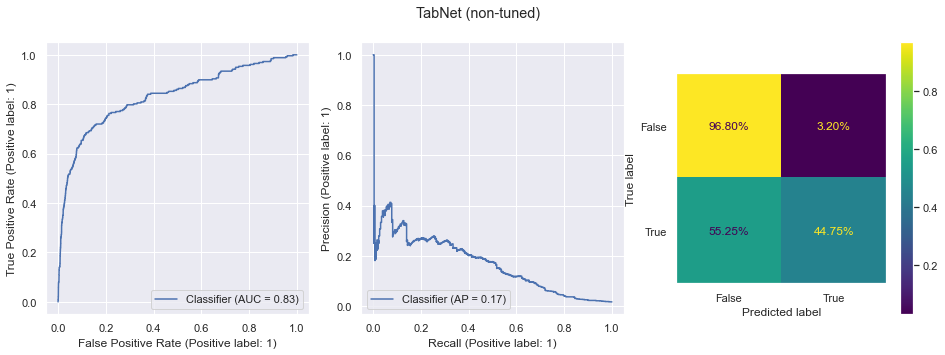

In [ ]:
evaluate(
    model, X_test.to_numpy(), y_test, "TabNet (non-tuned)", save="images/eval_tabnet.png"
)



#### Recalibrating

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.724524,0.045956,0.77821,0.830914,0.086787,0.185874


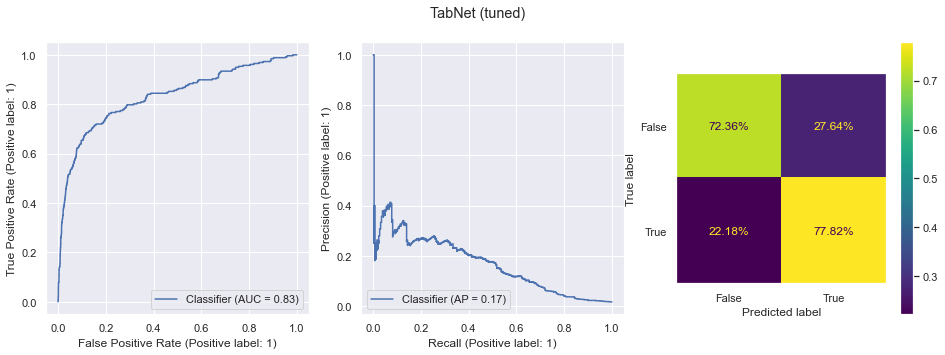

In [71]:
model = Notebook.MODELS["TabNet"]

threshold = get_threshold(
    y_test, 
    model.predict_proba(X_test.to_numpy())[:, 1],
    target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save="images/eval_calibrated_tabnet.png",
)


### Explanations

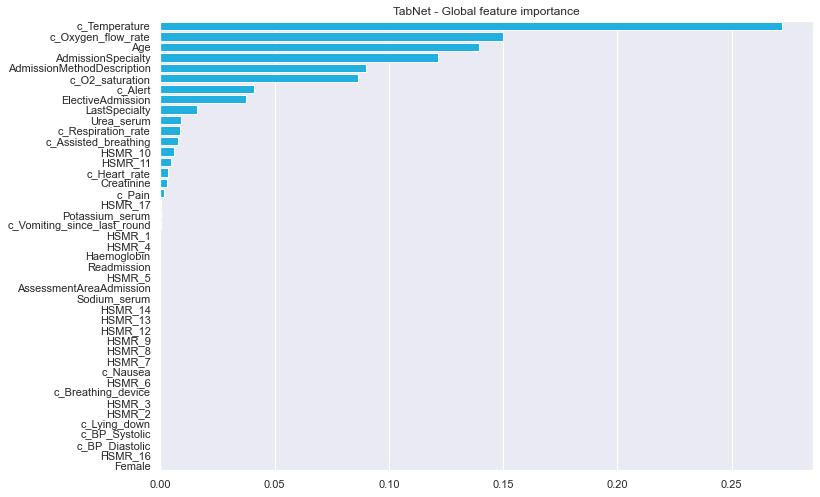

In [72]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("TabNet - Global feature importance")
plt.savefig("images/global_weights_tabnet.png", bbox_inches="tight")



In [73]:
positive_class_idx = np.where(model.predict(X_test.to_numpy()))[0][105]
explain_matrix, masks = model.explain(
    X_test.to_numpy()[positive_class_idx : positive_class_idx + 1]
)
list(sorted(zip(X_test.columns, explain_matrix[0]), key=lambda x: x[1]))


[('Female', 0.0),
 ('Age', 0.0),
 ('ElectiveAdmission', 0.0),
 ('AssessmentAreaAdmission', 0.0),
 ('AdmissionSpecialty', 0.0),
 ('LastSpecialty', 0.0),
 ('Haemoglobin', 0.0),
 ('Urea_serum', 0.0),
 ('Sodium_serum', 0.0),
 ('Potassium_serum', 0.0),
 ('Creatinine', 0.0),
 ('c_Respiration_rate', 0.0),
 ('c_Breathing_device', 0.0),
 ('c_Lying_down', 0.0),
 ('c_BP_Systolic', 0.0),
 ('c_BP_Diastolic', 0.0),
 ('c_Alert', 0.0),
 ('c_Pain', 0.0),
 ('c_Nausea', 0.0),
 ('c_Vomiting_since_last_round', 0.0),
 ('Readmission', 0.0),
 ('HSMR_1', 0.0),
 ('HSMR_2', 0.0),
 ('HSMR_3', 0.0),
 ('HSMR_4', 0.0),
 ('HSMR_5', 0.0),
 ('HSMR_6', 0.0),
 ('HSMR_7', 0.0),
 ('HSMR_8', 0.0),
 ('HSMR_9', 0.0),
 ('HSMR_10', 0.0),
 ('HSMR_11', 0.0),
 ('HSMR_12', 0.0),
 ('HSMR_13', 0.0),
 ('HSMR_14', 0.0),
 ('HSMR_16', 0.0),
 ('HSMR_17', 0.0),
 ('c_Heart_rate', 0.08059120923280716),
 ('c_Assisted_breathing', 0.09900437295436859),
 ('AdmissionMethodDescription', 0.14444537460803986),
 ('c_Temperature', 0.15278102457523346)

## Comparisons

In [29]:
y_preds = pd.DataFrame({
    key: model.predict({'LightGBM': X_test_lgbm,'Isolation Forest': X_test_if,'TabNet': X_test.to_numpy(),'XGBoost': X_test,'Random Forest': X_test,'Logistic Regression': X_test}[key])
    for key, model in Notebook.MODELS.items()
})

X has feature names, but IsolationForestWrapper was fitted without feature names


In [30]:
candidates = y_preds[y_preds.all(axis=1)].index

In [35]:
shap_values = {
    key: shap_value for key, (explainer, shap_value) in Notebook.EXPLAINERS.items()
}
shap_values['LightGBM'] = shap_values['LightGBM'][:,:,1]
shap_values['Random Forest'] = shap_values['Random Forest'][:,:,1]

In [42]:
for modelkey, shap_value in shap_values.items():
    fig = shap.plots.force(shap_value[candidates[0]])
    shap.save_html(f"images/comaprison_force_plot_{modelkey.replace(' ','')}.html", fig)
    
    print(modelkey)
    display(fig)
    

Logistic Regression


XGBoost


Random Forest


Isolation Forest


LightGBM
